In [45]:
# Import necessary libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define selected classes
selected_classes = ["Biking", "GolfSwing", "PushUps", "HandstandWalking", "JumpingJack"]

# Preprocessing parameters
target_size = (64, 64)  # Width, Height
grayscale = True        # Convert frames to grayscale

# Define dataset paths
train_path = "/kaggle/input/ucf101-action-recognition/train"
val_path = "/kaggle/input/ucf101-action-recognition/val"
test_path = "/kaggle/input/ucf101-action-recognition/test"

output_path_train = "/kaggle/working/processed_ucf101_train"
output_path_val = "/kaggle/working/processed_ucf101_val"
output_path_test = "/kaggle/working/processed_ucf101_test"

def create_output_dirs(paths):
    """Create output directories if they do not exist."""
    for path in paths:
        os.makedirs(path, exist_ok=True)

create_output_dirs([output_path_train, output_path_val, output_path_test])

# VideoFrameDataset class
class VideoFrameDataset(Sequence):
    def __init__(self, data_path, input_frames=5, future_frames=5, batch_size=8):
        self.data_path = data_path
        self.input_frames = input_frames
        self.future_frames = future_frames
        self.batch_size = batch_size
        self.video_files = []

        for class_name in os.listdir(data_path):
            class_path = os.path.join(data_path, class_name)
            if os.path.isdir(class_path):
                for video_file in os.listdir(class_path):
                    if video_file.endswith('.npy'):
                        self.video_files.append(os.path.join(class_path, video_file))

    def __len__(self):
        return len(self.video_files) // self.batch_size

    def __getitem__(self, idx):
        batch_files = self.video_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        X, y = [], []

        for file_path in batch_files:
            video = np.load(file_path)  # Video shape: (frames, H, W, 3)
            if len(video) >= (self.input_frames + self.future_frames):
                video = np.mean(video, axis=-1, keepdims=True)  # Convert to grayscale

                start_idx = np.random.randint(0, len(video) - (self.input_frames + self.future_frames) + 1)
                input_seq = video[start_idx:start_idx + self.input_frames]
                target_seq = video[start_idx + self.input_frames:start_idx + self.input_frames + self.future_frames]

                X.append(input_seq / 255.0)
                y.append(target_seq / 255.0)

        return np.array(X), np.array(y)

# ConvLSTMModel class
from tensorflow.keras import layers, Model
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class ConvLSTMModel(Model):
    def __init__(self, input_shape, future_frames=5, **kwargs):
        super().__init__(**kwargs)
        self.input_shape_config = input_shape
        self.future_frames = future_frames
        self.conv_lstm1 = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")
        self.conv_lstm2 = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=False, activation="relu")
        self.conv3d = layers.Conv3D(filters=future_frames, kernel_size=(3, 3, 3), padding="same", activation="sigmoid")

    def call(self, inputs):
        x = self.conv_lstm1(inputs)
        x = self.conv_lstm2(x)
        x = tf.expand_dims(x, axis=1)  # Add temporal dimension
        x = self.conv3d(x)
        x = tf.transpose(x, perm=[0, 4, 2, 3, 1])  # Adjust output shape
        return x

    def get_config(self):
        """Return the configuration of the model for serialization."""
        config = super().get_config()
        config.update({
            "input_shape": self.input_shape_config,
            "future_frames": self.future_frames
        })
        return config

    @classmethod
    def from_config(cls, config):
        """Reconstruct the model from its configuration."""
        return cls(**config)


@register_keras_serializable()
def ssim_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

@register_keras_serializable()
def combined_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim = ssim_loss(y_true, y_pred)
    return 0.8 * mse + 0.2 * ssim


# Train function
def train_model(model, train_dataset, val_dataset, epochs=50):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=combined_loss,
        metrics=["mse", ssim_loss]
    )
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
            ModelCheckpoint("convlstm_model.keras", save_best_only=True)
        ]
    )
    return history

# Create datasets
train_dataset = VideoFrameDataset(output_path_train, input_frames=10, future_frames=5, batch_size=8)
val_dataset = VideoFrameDataset(output_path_val, input_frames=10, future_frames=5, batch_size=8)
test_dataset = VideoFrameDataset(output_path_test, input_frames=10, future_frames=5, batch_size=8)

# Instantiate ConvLSTM model
model = ConvLSTMModel(input_shape=(10, 64, 64, 1), future_frames=5)

# Train the model
history = train_model(model, train_dataset, val_dataset, epochs=10)

# Save the final model
model.save("convlstm_model_final.keras")


# Evaluate the model on the test dataset
test_loss, test_mse, test_ssim = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test MSE: {test_mse:.4f}, Test SSIM Loss: {test_ssim:.4f}")





Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 293ms/step - loss: 0.2117 - mse: 0.0735 - ssim_loss: 0.7647 - val_loss: 0.1516 - val_mse: 0.0513 - val_ssim_loss: 0.5530
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 287ms/step - loss: 0.1461 - mse: 0.0451 - ssim_loss: 0.5505 - val_loss: 0.0980 - val_mse: 0.0187 - val_ssim_loss: 0.4152
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 304ms/step - loss: 0.1007 - mse: 0.0194 - ssim_loss: 0.4259 - val_loss: 0.0868 - val_mse: 0.0160 - val_ssim_loss: 0.3699
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 300ms/step - loss: 0.0861 - mse: 0.0164 - ssim_loss: 0.3649 - val_loss: 0.0842 - val_mse: 0.0153 - val_ssim_loss: 0.3596
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 287ms/step - loss: 0.0803 - mse: 0.0140 - ssim_loss: 0.3455 - val_loss: 0.0749 - val_mse: 0.0134 - val_ssim_loss: 0.3209
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 282ms/step - loss: 0.0698 - mse: 0.0123 - ssim_loss: 0.2997 - val_loss: 0.0831 - val_mse: 0.0173 - val_ssim_loss: 0.3462
Epoch 7/10
56/56 ━━━━━

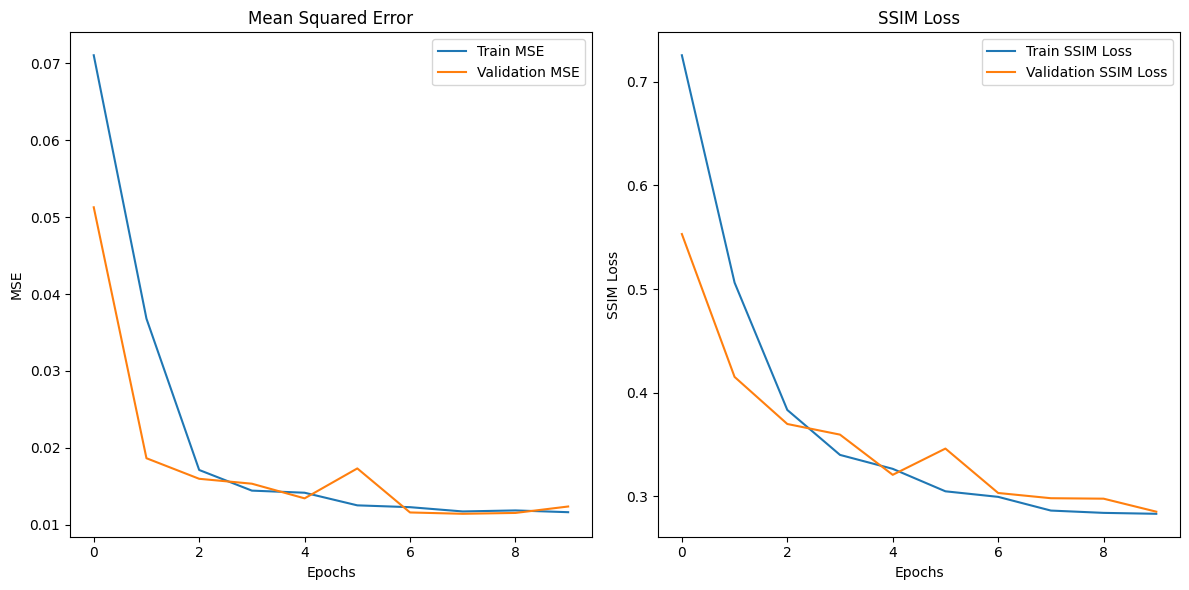

In [46]:
# Plot training history
def plot_training_history(history):
    """Plot the training and validation metrics."""
    plt.figure(figsize=(12, 6))

    # Plot MSE
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mse'], label='Train MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.title('Mean Squared Error')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()

    # Plot SSIM Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['ssim_loss'], label='Train SSIM Loss')
    plt.plot(history.history['val_ssim_loss'], label='Validation SSIM Loss')
    plt.title('SSIM Loss')
    plt.xlabel('Epochs')
    plt.ylabel('SSIM Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


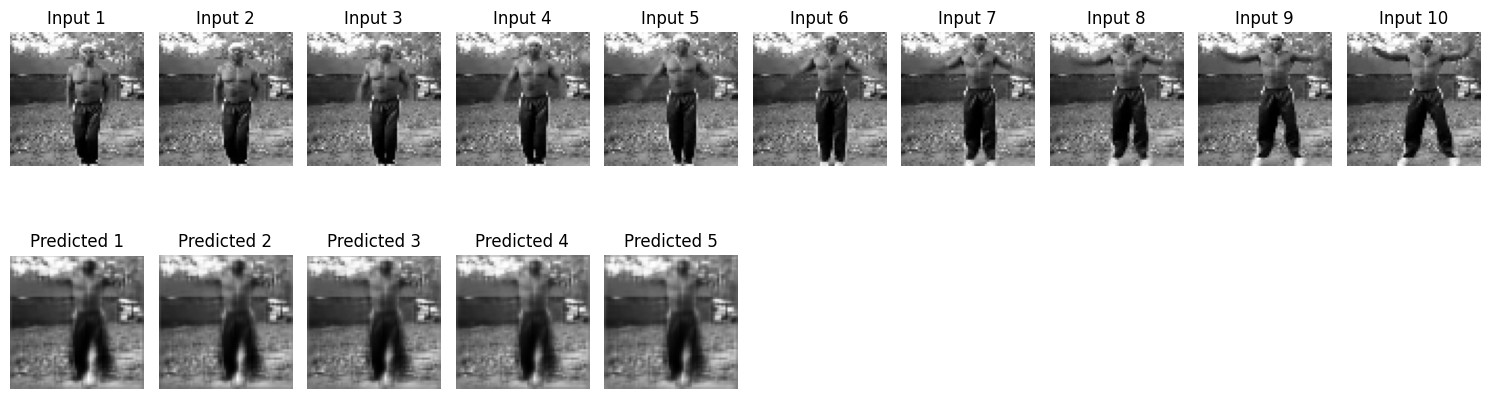

Video saved to: /kaggle/working/videos/generated_video4.mp4


In [60]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

# Load the preprocessed test frames
def load_frames(npy_path, input_frames=10):
    """
    Load input frames from a preprocessed .npy file.

    Args:
        npy_path (str): Path to the .npy file containing preprocessed frames.
        input_frames (int): Number of frames to load as input.

    Returns:
        np.ndarray: Input frames ready for prediction.
    """
    frames = np.load(npy_path)
    if frames.shape[0] < input_frames:
        raise ValueError(f"File {npy_path} contains fewer than {input_frames} frames.")
    return frames[:input_frames]  # Extract the first `input_frames`

# Create a video file from frames
def create_video_from_frames(frames, output_path, fps=10):
    """
    Generate a video file from a sequence of frames.

    Args:
        frames (np.ndarray): Array of frames with shape (num_frames, height, width, channels).
        output_path (str): Path to save the generated video file.
        fps (int): Frames per second for the output video.

    Returns:
        None
    """
    if frames.ndim == 4 and frames.shape[-1] == 1:  # Grayscale (expand to 3 channels for video)
        frames = np.repeat(frames, 3, axis=-1)
    elif frames.ndim != 4 or frames.shape[-1] not in [1, 3]:
        raise ValueError("Frames should have shape (num_frames, height, width, channels).")

    height, width, channels = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
        frame = (frame * 255).astype(np.uint8)  # Convert to uint8 for video
        video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Write frame

    video_writer.release()
    print(f"Video saved to: {output_path}")

# Visualize input and predicted frames
def visualize_frames(input_frames, predicted_frames):
    """
    Visualize input frames and predicted frames.

    Args:
        input_frames (np.ndarray): Array of input frames.
        predicted_frames (np.ndarray): Array of predicted frames.

    Returns:
        None
    """
    num_input = input_frames.shape[0]
    num_predicted = predicted_frames.shape[0]

    plt.figure(figsize=(15, 5))

    # Display input frames
    for i in range(num_input):
        plt.subplot(2, max(num_input, num_predicted), i + 1)
        plt.imshow(input_frames[i].squeeze(), cmap='gray' if input_frames.shape[-1] == 1 else None)
        plt.axis('off')
        plt.title(f"Input {i+1}")

    # Display predicted frames
    for i in range(num_predicted):
        plt.subplot(2, max(num_input, num_predicted), num_input + i + 1)
        plt.imshow(predicted_frames[i].squeeze(), cmap='gray' if predicted_frames.shape[-1] == 1 else None)
        plt.axis('off')
        plt.title(f"Predicted {i+1}")

    plt.tight_layout()
    plt.show()

# Generate video and visualize frames
def generate_and_visualize_video(npy_path, model, output_video_path, input_frames=10, pred_frames=5, fps=10):
    """
    Generate a video from input frames and model predictions, and visualize them.

    Args:
        npy_path (str): Path to the preprocessed .npy file.
        model (tf.keras.Model): Trained model for predicting future frames.
        output_video_path (str): Path to save the output video.
        input_frames (int): Number of input frames.
        pred_frames (int): Number of predicted frames.
        fps (int): Frames per second for the video.

    Returns:
        None
    """
    # Load input frames
    input_frames_data = load_frames(npy_path, input_frames=input_frames)

    # Normalize and cast to float32
    input_frames_data = input_frames_data.astype('float32') / 255.0

    # Predict future frames
    predicted_frames = model.predict(input_frames_data[np.newaxis, ...])  # Add batch dimension
    predicted_frames = np.squeeze(predicted_frames, axis=0)  # Remove batch dimension

    # Combine input and predicted frames for the video
    all_frames = np.concatenate((input_frames_data, predicted_frames), axis=0)

    # Visualize input and predicted frames
    visualize_frames(input_frames_data, predicted_frames)

    # Create and save the video
    create_video_from_frames(all_frames, output_video_path, fps=fps)

# Main function
if __name__ == "__main__":
    # Example .npy path
    npy_path = "/kaggle/working/processed_ucf101_test/JumpingJack/v_JumpingJack_g02_c02.npy"

    # Load the trained ConvLSTM model
    model = load_model(
        "convlstm_model_final.keras",
        custom_objects={
            "ConvLSTMModel": ConvLSTMModel,  # Custom ConvLSTM model
            "ssim_loss": ssim_loss,         # Custom SSIM loss function
            "combined_loss": combined_loss  # Custom combined loss function
        }
    )

    # Create a directory for videos
    os.makedirs("/kaggle/working/videos", exist_ok=True)

    # Define output video path
    output_video_path = "/kaggle/working/videos/generated_video4.mp4"

    # Generate and visualize the video
    generate_and_visualize_video(npy_path, model, output_video_path, input_frames=10, pred_frames=5, fps=10)


**________________________________________________________________________________________________**

In [62]:
!pip install streamlit


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 58.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.9 MB/s eta 0:00:0000:01


In [64]:
!streamlit run app.py --server.port 8501 --server.headless true


Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py


In [66]:
%%writefile app.py
import streamlit as st
import os

# Define available classes and models
classes = ["Biking", "GolfSwing", "PushUps", "HandstandWalking", "JumpingJack"]
models = ["ConvLSTM", "PredRNN", "Transformer"]

# Base path where videos are stored
video_base_path = "/kaggle/working/videos"

st.title("Video Prediction Viewer")

# Select a model
model_name = st.selectbox("Select a Model", models)

# Select a class
class_name = st.selectbox("Select a Class", classes)

# Generate the corresponding video filename
video_filename = f"{class_name}_{model_name}.mp4"

# Generate full video path
video_path = os.path.join(video_base_path, video_filename)

# Check if the video exists
if os.path.exists(video_path):
    st.video(video_path)
else:
    st.warning(f"The video for {class_name} using {model_name} is not available.")


Overwriting app.py


In [67]:
!streamlit run app.py --server.port 8501 --server.headless true





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.19.2.2:8501
  External URL: http://35.222.195.63:8501

^C
  Stopping...


In [68]:
!streamlit run app.py --server.port 8501 --server.headless true





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.19.2.2:8501
  External URL: http://35.222.195.63:8501

^C
  Stopping...
